# Hand gesture classification with Electromyography (EMG) 

The goal of this notebook is to explore the nature of the signal recorded from electromyograms, i.e. timeseries of electrical activity of muscle tissue recorded by 8 electrodes placed on the arm skin - see Figure 1 (Left). 

We investigate the performance of geometric and topological methods to perform hand gesture classification from the corresponding timeseries, and compare them with classical methods from `sklearn` and neural network methods using `keras`/`tensorflow`. The 4 classes of gestures are: "paper", "rock", "scissors", "ok" - see Figure 1 (Right).


<table><tr>
<td> <img src="emg_wristband.png" style="width: 200px;"/> </td>
<td> <img src="paper_rock_scissors.png" style="width: 300px;"/> </td>
</tr></table>

Figure 1. Left: EMG device: Armband with 8 electrodes recording the electrical activity of the arm's muscle tissues. Right: Three out of the four hand gestures classes considered, here "paper", "rock", "scissors".

# 1. Introduction and Motivation

Human-computer interactions (HCI) mostly leverage the use of mouses and keyboards. In recent years however, new signal recording modalities have been introduced and studied to enhance the way humans interact with machines. Among them, superficial electromyography (sEMG or EMG) has been used in medical applications, for instance to investigate a wide range of motor and neural conditions or to perform prostetic controls. An EMG device can be used to record static signs that are linked with different actions: moving a cursor and clicking, sign recognition for command based personal assistants, among others.

The EMG modality is particularly interesting due to its non-invasiness and its price, typically cheaper that other medical devices. Yet, many challenges remain for this technology to be widely adopted, and among them: the robustness of the signal detected. From one session to another, the placement of the wearable EMG on the subject's sking changes. This leads to underperforming algorithms, or to the need of re-calibrating the algorithms to the new placement at each session. Furthermore, the physiology of different subjects being different, the algorithms also perform traditionally badly when they are calibrated on a subject but tested on another one.

In these experiments, we evaluate the difference in performance (measured as the accuracy of sign recognition) between three different real life situations. We change the conditions of training (when the user records signs or "calibrates" the device) and testing (when the app guesses which sign the user is doing):

- What is the accuracy when doing sign recognition right after training?
- What is the accuracy when calibrating, removing and replacing the armband at the same position and then testing? 
- What is the accuracy when calibrating, removing the armband and giving it to someone else that is testing it without calibration?

To simulate these situations, we record data from two different users (rr and mg) and in two different sessions (s1 or s2). The user put the bracelet before every session and remove it after every session.

The EMG timeseries are acquired from somOS-interface: an sEMG armband that interacts via bluetooth with an Android smartphone. The data is directly available from the `geomstats` repository, but you can contact Marius Guerard (marius.guerard@gmail.com) or Renaud Renault (renaud.armand.renault@gmail.com) to get assistance on how to make this kind of armband yourself. 

## Outline

In this notebook, we will:
- Process the EMG signals into covariance matrices that we can manipulate with geomstats tools.
- Apply Machine Learning algorithms to classify four different hand gestures: Rock, Paper, Scissors, Ok.
- Benchmark different methods: using Riemanian metrics, projecting on tangent space, Euclidean metric, etc.

# 2. Analysis

We import required Python packages.

In [1]:
import sys
!{sys.executable} -m pip install keras tensorflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib
matplotlib.interactive(True)
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

import geomstats.backend as gs
gs.random.seed(2021)

INFO: Using numpy backend


## 2.1. Dataset description


The raw EMG data is organized in a pandas Dataframe as follows:
- Each row corresponds to one acquisition, there is an acquisition every ~4 ms for 8 electrodes which correspond to a 250Hz acquisition rate.
- The `time` column is in ms.
- The columns `c0` to `c7` correspond to the electrical value recorded at each of the 8 electrodes (arbitrary unit).
- The `label` column corresponds to the sign being recorded by the user at this time point ('rest', 'rock', 'paper', 'scissors', or 'ok). 'rest' correspond to a rested arm.
- the `exp` column stands for "experiment" and identifies the user (rr and mg) and the session (s1 or s2).

In [4]:
N_ELECTRODES = 8
N_SIGNS = 4  # The 'rest' sign will be removed from the analysis.

In [5]:
import geomstats.datasets.utils as data_utils

data = data_utils.load_emg()

In [6]:
data.head()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
0,23,127,123,128,134,125,128,130,124,rest,mg_s1
1,28,126,130,128,119,129,128,126,133,rest,mg_s1
2,32,129,130,127,125,129,129,127,130,rest,mg_s1
3,36,127,128,126,123,128,127,125,131,rest,mg_s1
4,40,127,128,129,124,127,129,127,128,rest,mg_s1


For simplicity, we remove the sign 'rest' in what follows.

In [7]:
data = data[data.label != 'rest']
data.head()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
6070,25006,128,128,126,127,127,126,127,127,rock,mg_s1
6071,25009,127,126,128,122,129,126,127,128,rock,mg_s1
6072,25013,124,126,127,125,128,130,128,128,rock,mg_s1
6073,25016,129,129,127,131,127,126,129,126,rock,mg_s1
6074,25020,128,127,126,129,127,128,126,127,rock,mg_s1


We explore the dataset by showing illustrative time-series recorded from the 8 electrodes.

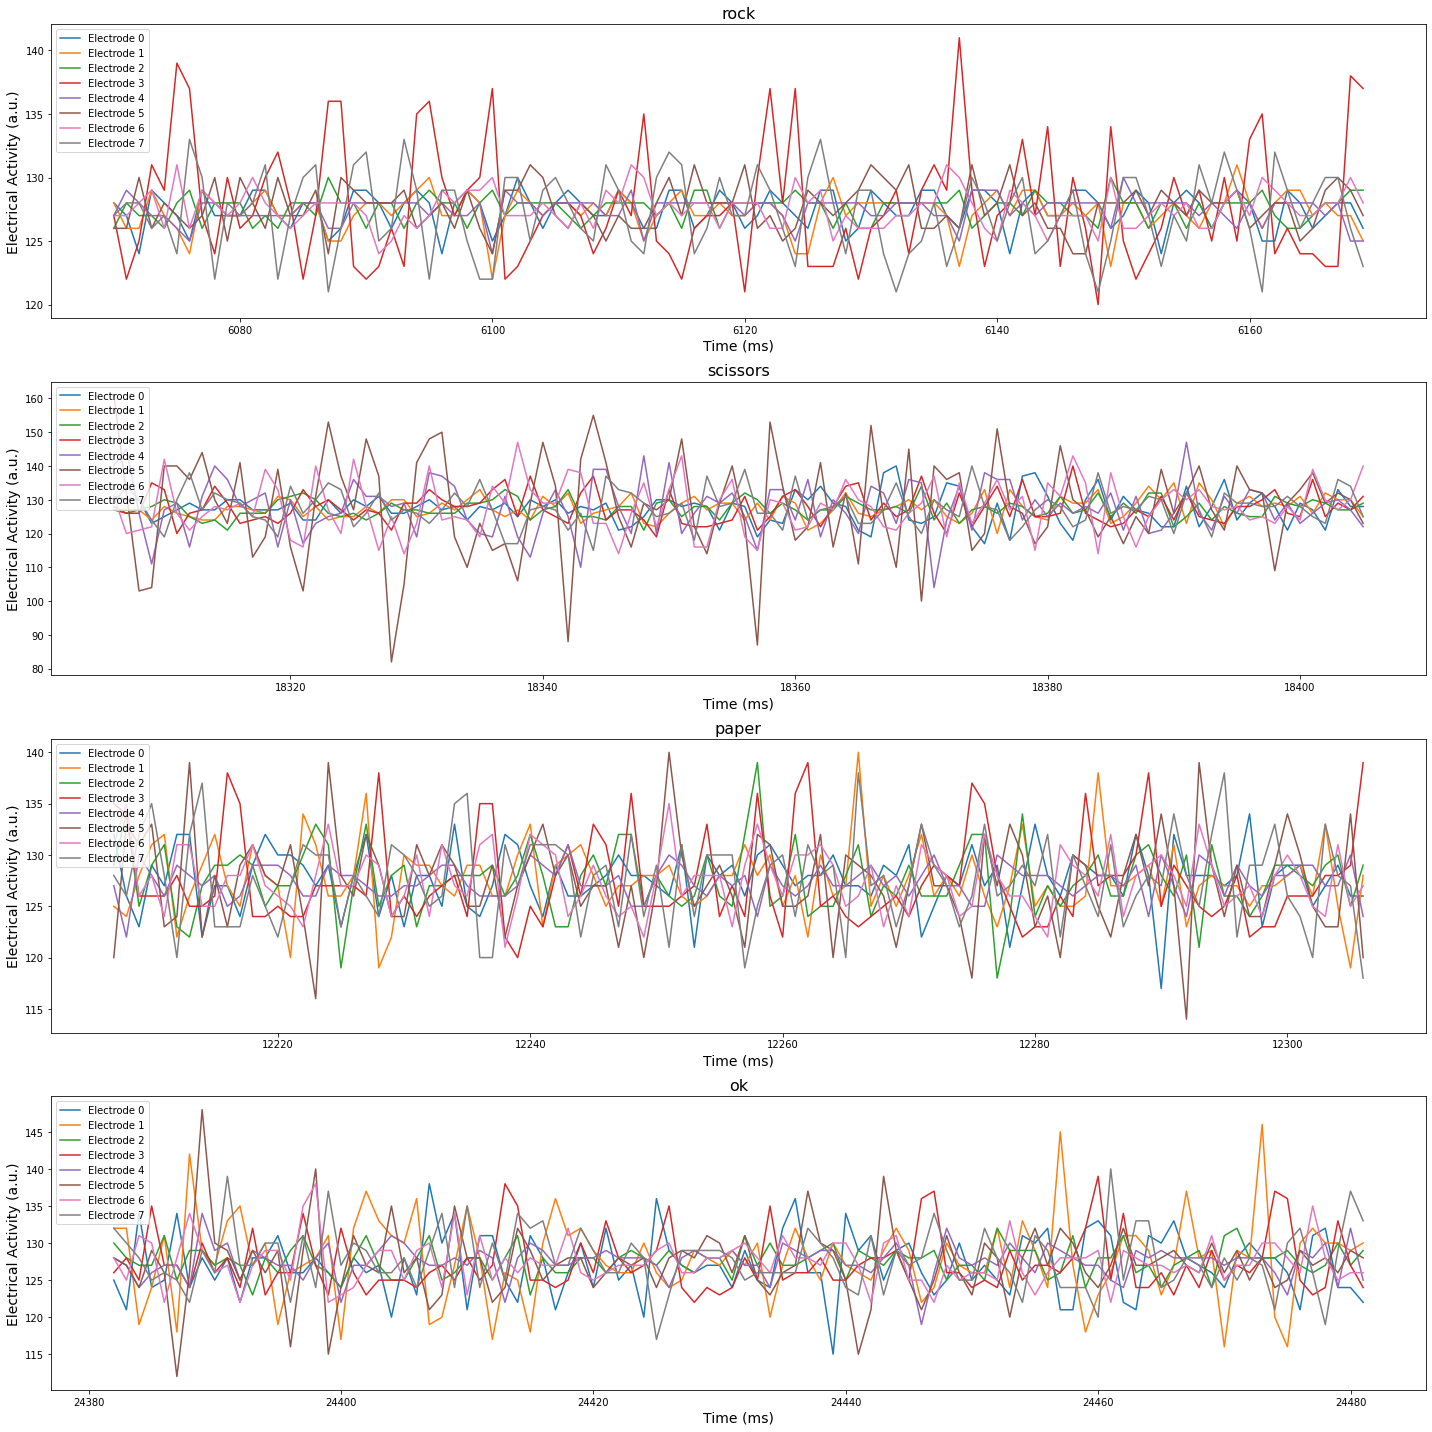

In [8]:
fig, ax = plt.subplots(N_SIGNS, figsize=(20, 20))
label_list = ['rock', 'scissors', 'paper', 'ok']
for i, label_i in enumerate(label_list):
    ax[i].title.set_text(label_i)
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Electrical Activity (a.u.)')
    sign_df = data[data.label==label_i].iloc[:100]
    for electrode in range(N_ELECTRODES):
        ax[i].plot(
            sign_df.iloc[:, 1 + electrode], 
            label=f"Electrode {electrode}")
    ax[i].legend(loc="upper left")
    
plt.tight_layout()

We see that the signal is already centered by the hardware (with an artificial mean between 125 and 130 a.u.). Indeed, as the electrodes are bipolar, the mean of the signal does not contain relevant information, and it is the variance that represents the muscle activations. Covariance contains information about the co-activation of the muscle groups sensed by each electrode, and is therefore a natural statistics to study hand signs. Covariance matrices belong to the group of Symmetric Positive Definite (SPD) matrices that are well described my Riemannian geometry. 

## 2.2. Preprocessing into covariance matrices

We preprocess the data into covariance matrices using `geomstats` tools.

In [9]:
import numpy as np

N_STEPS = 100
LABEL_MAP = {'rock': 0, 'scissors': 1, 'paper': 2, 'ok': 3}
MARGIN = 1000

We unpack the timeseries data into arrays to batch them and build associated covariance matrices.

In [10]:
data_dict = {
    'time': gs.array(data.time),
    'raw_data': gs.array(data[['c{}'.format(i) for i in range(N_ELECTRODES)]]),
    'label': gs.array(data.label),
    'exp': gs.array(data.exp)}

Utils from `geomstats` help convert the timeseries data into covariance matrices.

In [11]:
from geomstats.datasets.prepare_emg_data import TimeSeriesCovariance

cov_data = TimeSeriesCovariance(data_dict, N_STEPS, N_ELECTRODES, LABEL_MAP, MARGIN)
cov_data.transform()

Using `geomstats`, we check that these matrices belong to the space of Symmetric Positive Definite (SPD) matrices.

In [12]:
import geomstats.geometry.spd_matrices as spd

manifold = spd.SPDMatrices(N_ELECTRODES)

In [13]:
gs.all(manifold.belongs(cov_data.covs))

True

Now that we have preprocessed the timeseries into covariance matrices, we further explore the dataset by plotting the mean covariance matrices of each sign, using either a Euclidean mean or a Riemannian mean from `geomstats`.

### Covariances plot of the euclidean average

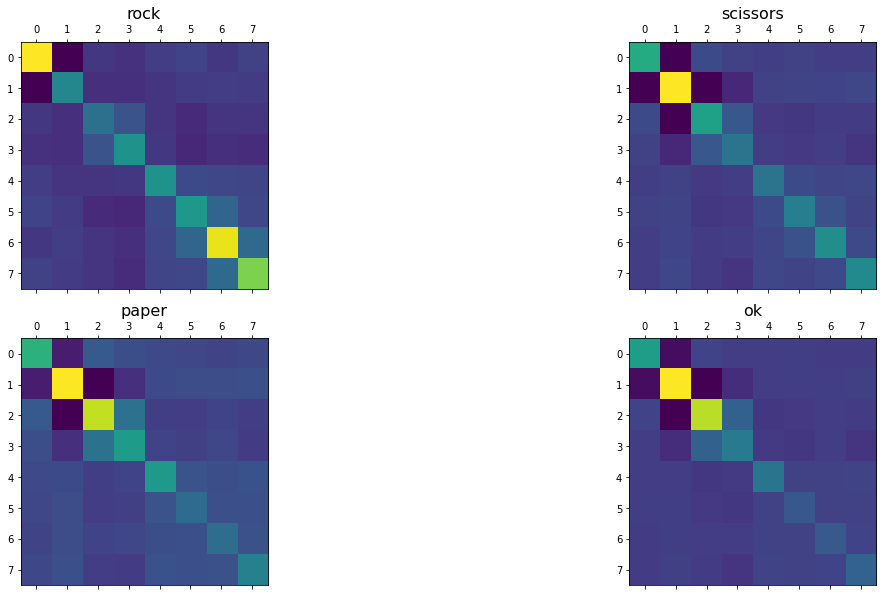

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_cov = np.mean(sign_cov_mat, axis=0)
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

Looking at the euclidean average of the spd matrices for each sign, does not show a striking difference between 3 of our signs (scissors, paper, and ok). Minimum Distance to Mean (MDM) algorithm will probably performed poorly if using euclidean mean here.

### Covariances plot of the Frechet Mean of the affine invariant metric

In [15]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.spd_matrices import SPDMetricAffine

In [16]:
metric_affine = SPDMetricAffine(N_ELECTRODES)
mean_affine = FrechetMean(metric=metric_affine, point_type='matrix')

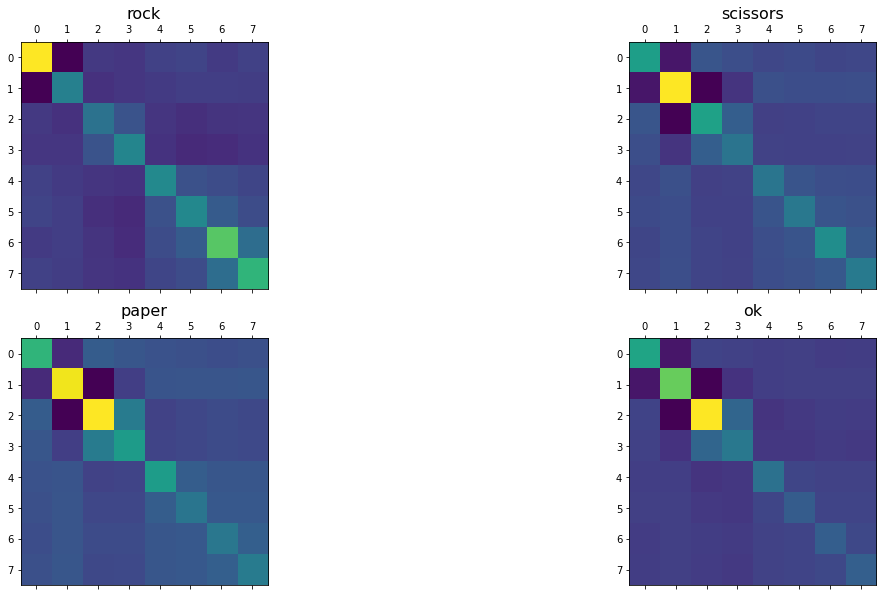

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_affine.fit(X=sign_cov_mat)
    mean_cov = mean_affine.estimate_
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

We see that the average matrices computed using the affine invariant metric are now more differenciated from each other and can potentially give better results, when using MDM to predict the sign linked to a matrix sample.

## 2. 3. Sign Classification

We are now going to train some classifiers on those matrices to see how we can accurately discriminate these 4 hand positions.
The baseline accuracy is defined as the accuracy we get by randomly guessing the signs. In our case, the baseline accuracy is 25%.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

N_EPOCHS is the number of epochs on which to train the DNN. Recommended is ~100

In [20]:
N_EPOCHS = 10
N_FEATURES = int(N_ELECTRODES * (N_ELECTRODES + 1) / 2)

## A. Test on the same session and user as Training/Calibration 

In this first part we are training our model on the same session that we are testing it on. In real life, it corresponds to a user calibrating his armband right before using it. To do this, we are splitting every session in k-folds, training on $(k-1)$ folds to test on the $k^{th}$ last fold. 


In [21]:
class ExpResults:
    """Class handling the score collection and plotting among the different experiments.
    """
    
    def __init__(self, exps):
        self.exps = exps
        self.results = {}
        self.exp_ids = {}
        # Compute the index corresponding to each session only once at initialization.
        for exp in set(self.exps):
            self.exp_ids[exp] = np.where(self.exps==exp)[0]
    
    def add_result(self, model_name, model, X, y):
        """Add the results from the cross validated pipeline.
        
        For the model 'pipeline', it will add the cross validated results of every session in the model_name
        entry of self.results.
        
        Parameters
        ---------- 
        model_name : str
            Name of the pipeline/model that we are adding results from.
        model : sklearn.pipeline.Pipeline
            sklearn pipeline that we are evaluating.
        X : array
            data that we are ingesting in the pipeline.
        y : array
            labels corresponding to the data.
        """
        self.results[model_name] = {'fit_time': [], 'score_time': [], 'test_score': [], 'train_score': []}
        for exp in self.exp_ids.keys():
            ids = self.exp_ids[exp]
            exp_result = cross_validate(pipeline, X[ids], y[ids], return_train_score=True)
            for key in exp_result.keys():
                self.results[model_name][key] += list(exp_result[key])
        print('Average training score: {}, Average test score: {}'.format(
            np.mean(self.results[model_name]['train_score']), 
            np.mean(self.results[model_name]['test_score'])))
        
    def plot_results(self, title, variables, err_bar=None, save_name=None, xlabel='Model', ylabel='Acc'):
        """Plot bar plot comparing the different pipelines' results.
        
        Compare the results added previously using the 'add_result' method with bar plots.
        
        Parameters
        ---------- 
        title : str
            Title of the plot.
        variables : list of array
            List of the variables to plot (e.g. train_score, test_score,...)
        err_bar : list of float
            list of error to use for plotting error bars. If None, std is used by default.
        save_name : str
            path to save the plot. If None, plot is not saved.
        xlabel : str
            Label of the x-axis.
        ylabel : str
            Label of the y-axis.
        """
        ### Some defaults parameters.
        w = 0.5                                                                                                                                                                        
        colors = ['b', 'r', 'gray']
        
        ### Reshaping the results for plotting.
        x_labels = self.results.keys()
        list_vec = []
        for variable in variables:
            list_vec.append(np.array([self.results[model][variable] for model in x_labels]).transpose())
        rand_m1 = lambda size: np.random.random(size) * 2 - 1
        
        ### Plots parameters.                                                                                                                                                                                   
        label_loc = np.arange(len(x_labels))                                                                                                                                            
        center_bar = [w * (i - 0.5) for i in range(len(list_vec))]
        
        ### Plots values.                                                                                                                                                                                       
        avg_vec = [np.nanmean(vec, axis=0) for vec in list_vec]
        if err_bar is None:
            err_bar = [np.nanstd(vec, axis=0) for vec in list_vec]
        
        ### Plotting the data.                                                                                                                                                                                  
        fig, ax = plt.subplots(figsize=(20, 15))
        for i, vec in enumerate(list_vec):
            label_i = variable[i] + ' (n = {})'.format(len(vec))
            rects = ax.bar(label_loc + center_bar[i], avg_vec[i], w, label=label_i,
                           yerr=err_bar[i], color=colors[i], alpha=0.6)
            for j, x in enumerate(label_loc):
                ax.scatter((x + center_bar[i]) + rand_m1(vec[:, j].size) * w/4,
                           vec[:, j], color=colors[i], edgecolor='k')

        # Add some text for labels, title and custom x-axis tick labels, etc.                                                                                                                                   
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(label_loc)
        ax.set_xticklabels(x_labels)
        ax.legend()
        plt.legend()
        
        ### Saving the figure with a timestamp as a name.                                                                                                                                                       
        if save_name is not None:
            plt.savefig(save_name)


In [22]:
exp_arr = data.exp.iloc[cov_data.batches]
intra_sessions_results = ExpResults(exp_arr)

### A.0. Using Logistic Regression on the vectorized Matrix (Euclidean Method)

In [23]:
pipeline = Pipeline(
    steps=[('standardize', StandardScaler()),
           ('logreg', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])

intra_sessions_results.add_result(model_name='logreg_eucl', model=pipeline, X=cov_data.covecs, y=cov_data.labels)

Average training score: 0.993744507297136, Average test score: 0.9165487438228214


### A.1. Using DNN on the vectorized Matrix (Euclidean Method)

In [24]:
def create_model(weights='initial_weights.hd5', n_features=N_FEATURES, n_signs=N_SIGNS):
    """Function to create model, required for using KerasClassifier and wrapp a Keras model inside a 
    scikitlearn form.
    We added a weight saving/loading to remove the randomness of the weight initialization (for better comparison).
    """
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_features, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_signs, activation='softmax'),
])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=N_FEATURES)

Use the line below to generate the `initial_weights.hd5` file.

In [25]:
generate_weights = create_model(weights=None)

In [26]:
pipeline = Pipeline(
    steps=[('standardize', StandardScaler()),
           ('dnn', KerasClassifier(build_fn=create_model, epochs=N_EPOCHS, verbose=0))])

intra_sessions_results.add_result(model_name='dnn_eucl', model=pipeline, X=cov_data.covecs, y=cov_data.labels)

Average training score: 0.9496337920427322, Average test score: 0.8181855365633964


### A.2. Using Tangent space projection + Logistic Regression

In [27]:
from geomstats.learning.preprocessing import ToTangentSpace

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric_affine)),
           ('standardize', StandardScaler()),
           ('logreg', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])

intra_sessions_results.add_result(model_name='logreg_affinvariant_tangent', model=pipeline, X=cov_data.covs, y=cov_data.labels)

Average training score: 0.9959200098767251, Average test score: 0.9195041875438875


### A.3. Using Tangent space projection + DNN

In [28]:
pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric_affine)),
           ('standardize', StandardScaler()),
           ('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=N_EPOCHS, verbose=0))])

intra_sessions_results.add_result(model_name='dnn_affinvariant_tangent', model=pipeline, X=cov_data.covs, y=cov_data.labels)

Average training score: 0.9610635310411453, Average test score: 0.8335487261414528


We observe that our training scores are way higher than our testing scores in all these models. A grid search on regularization parameters should be used to correct for the over-fitting.

## 2.4. Role of Geomstats/Giotto-TDA in the analysis

The package `geomstats` is instrumental in this analysis. It allows to perform machine learning methods using Riemannian metric without having to re-implement the differential geometry computations. The class `ToTangentSpace` is also convenient to simply transform the data on the SPD manifold into tangent vectors and apply standard learning methods on them.

# 3. Benchmark

The analysis in this submission compares geometric methods (using a Riemannian metric) with standard Euclidean methods. The following plot summarizes our finding, by directly comparing the accuracy of each method in the classification task.

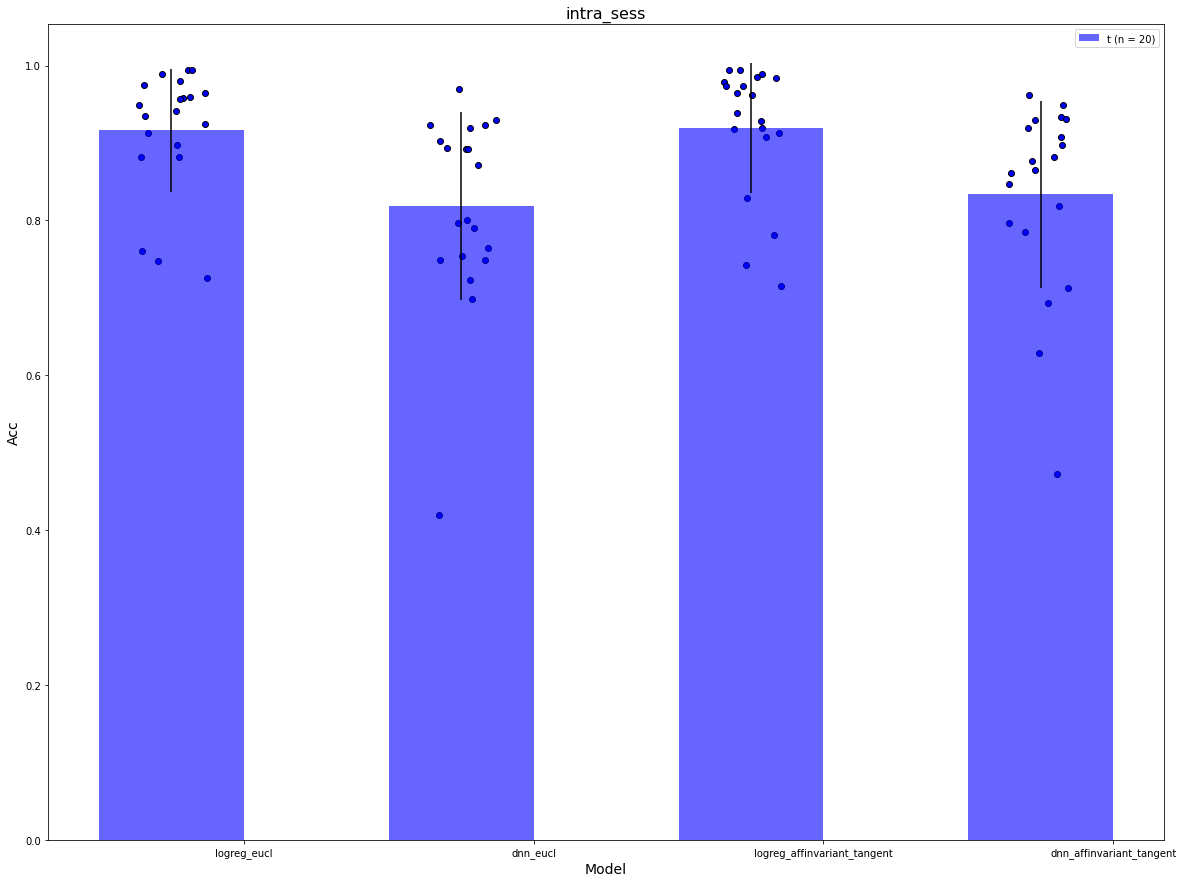

In [29]:
intra_sessions_results.plot_results('intra_sess', ['test_score'])

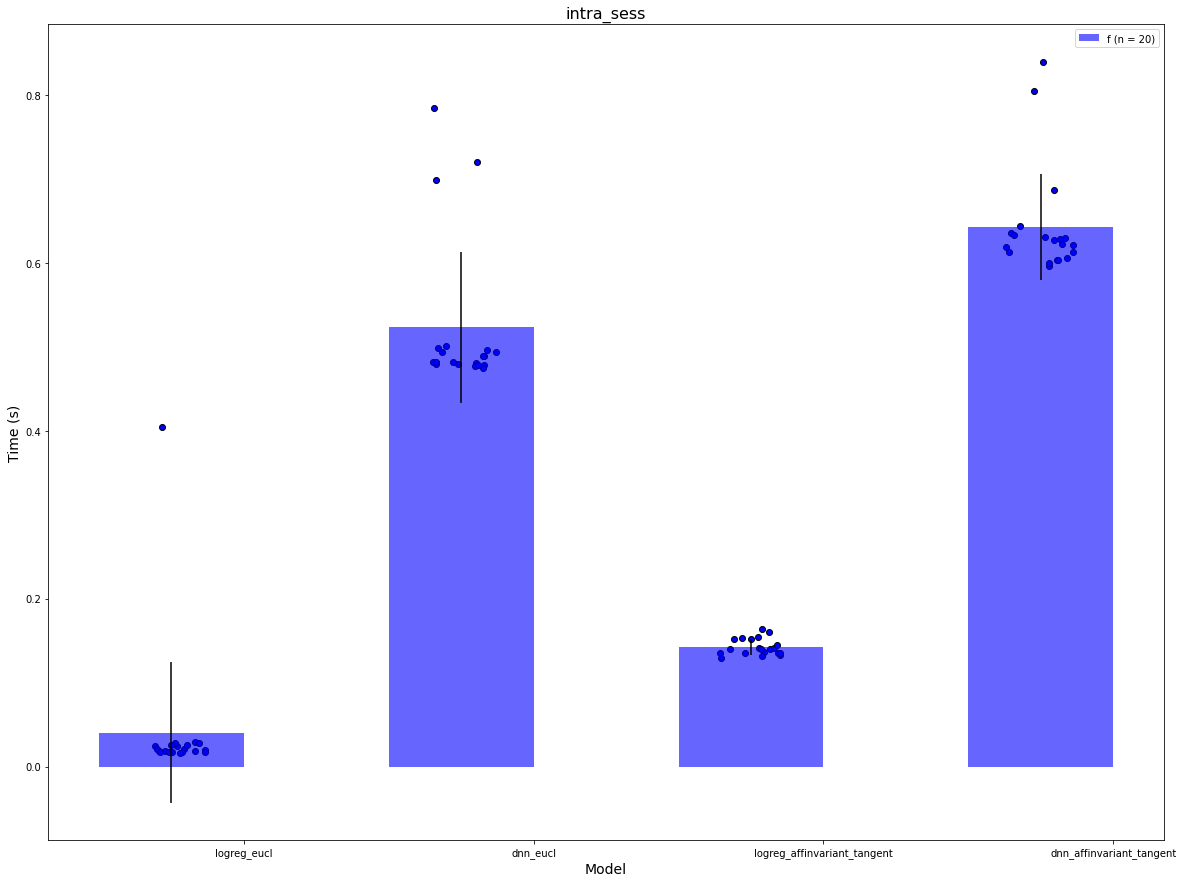

In [30]:
intra_sessions_results.plot_results(
    'intra_sess', ['fit_time'], ylabel='Time (s)')

In this first naive analysis, we don't see any accuracy improvement by using other geometric methods. However, the covariance plots suggests that if we were to use the Minimum Distance to Mean (MDM) algorithm to classify our signs, we would probably do! 

In term of the method's training speed comparison, it looks like for simple algorithm as logistic regression, using Riemannian geometry does add a non negligible time, but that for more complexe methods as Deep Neural Network, the cost of using Riemannian geometry is negligible in comparison with the overall cost of training the network.

# 4. Limitations and perspectives

## Limitations of this analysis

In this analysis, we have focused on one geometry of the manifold of the SPD matrices: the geometry of the affine-invariant Riemannian metric. It would be interesting to investigate the performances of the different metrics that can equip the SPD manifold, implemented in `geomstats`.

We have also only considered supervised learning methods. It would be interesting to explore how unsupervised learning methods behave on this dataset, and compare the non-geometric and geometric approaches.

Furthermore, we did not perform any benchmark in terms of the methods' testing speed. Efficiency of each method should be taken into account in further works in order to give a clearer picture.

Another interesting use case, not explored in this notebook, would be to test what is the accruacy when calibrating, removing the armband and giving it to someone else that is calibrating it on its own arm before testing it. The idea being that transfer learning might help getting better results (or faster calibration) than calibrating on one user.

## Limitation of Geomstats and Giotto-TDA

Since the geometric methods did not seem provide any accuracy gain, it is unclear how the SPD manifold of geomstats can make a difference in such analysis.

## Proposed features for Geomstats and Giotto-TDA

As of today, there is no code profiling in geomstats. It would be interesting from a user perspective to understand the efficiency of several geomstats functions.

It would also be interesting if `geomstats` could provide more documentation about the typical use cases of the different metrics on the SPD manifold, and perhaps recommendations as to which metric is expected to be the most useful in a given situation.